# ATP Tennis Data - Player Diff Stats + One Hot Encoding (All Categorical Data)


In our previous [notebook](https://github.com/sv650s/sb-capstone2/blob/master/notebooks/5.2-atp_diff-ohe.ipynb), we did not see any improvement from encoding more categorical columns in our model. In fact we saw as slight decrease in our precision for predicting losses

In this notebook, we will run the same algorithms but we will add historical data from player 1 and 2. Historical data was created in this [notebook](https://github.com/sv650s/sb-capstone2/blob/master/notebooks/6-apt_advanced_feature_engineering-history.ipynb) where we aggregated match data for each player for the most recent 5 matches leading up to each match

Data that we obtained for each player:

* wins - matches won
* losses - matches lost
* games won
* sets won
* games lost
* sets lost
* winning percentage = wins / (wins + losses)
* games won percetnage = games won / (games won + games lost)
* sets won percentage = sets won / (sets won + sets lost)

We will see if this data helps improve our models

### Results from Decision Tree Classifier with player diff + one hot encoded player ID's:

```
Model Score: 0.9372638963842418

              precision    recall  f1-score   support

        Loss       0.93      0.94      0.94      7378
         Win       0.94      0.93      0.94      7446

    accuracy                           0.94     14824
   macro avg       0.94      0.94      0.94     14824
weighted avg       0.94      0.94      0.94     14824
```

# Summary of Results


* Decision Tress is still our best model, although adding this data decreased our performance to be about 1% (back to diff+ohe_player performance). Our accuracty for both wins and losses are down to 92% now with lower recall as well
```
Model Score: 0.9191851052347545

              precision    recall  f1-score   support

        Loss       0.92      0.92      0.92      7378
         Win       0.92      0.92      0.92      7446

    accuracy                           0.92     14824
   macro avg       0.92      0.92      0.92     14824
weighted avg       0.92      0.92      0.92     14824
```


* No change in performance for Ada Boost or Logistic regression or Gradient Boost
* Around 5% decrease in accuracy for KNN and Random Forest


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from datetime import datetime
import pickle
import json
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import jupyter_util as ju
from util.model_util import ModelWrapper

%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)

DESCRIPTION = "diff-ohe-history"


# update this
FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features-diff-ohe-matchup5.csv'

START_YEAR = 1998
END_YEAR = 2019

MODEL_TEMPLATE_NAME = f'{START_YEAR}-{END_YEAR}-{DESCRIPTION}.pkl'

LABEL_COL = 'p1_winner'

# random seed
RSTATE = 1
N_JOBS = 4
MAX_ITER = 100



ModelWrapper.init(description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR, 
                 model_file_format = MODEL_TEMPLATE_NAME)

In [2]:
X_train, X_test, y_train, y_test = ju.get_data(FEATURE_FILE, LABEL_COL, START_YEAR)

(59293, 5283)


Our dataset actually has both historical data as well as matchup data. We will remove the matchup columns from the dataset

In [5]:
import re
matchup_columns = [col for col in X_train.columns if re.search("matchup", col)]
print(f'Before: X_train.shape {X_train.shape} X_test.shape {X_test.shape}')
X_train = X_train.drop(matchup_columns, axis=1)
X_test = X_test.drop(matchup_columns, axis=1)
print(f'After: X_train.shape {X_train.shape} X_test.shape {X_test.shape}')

Before: X_train.shape (44469, 5283) X_test.shape (14824, 5283)
After: X_train.shape (44469, 5269) X_test.shape (14824, 5269)


# Logistic Regression

In [6]:

# train our model

lr = ModelWrapper(LogisticRegression(n_jobs = N_JOBS, verbose = 1, random_state = RSTATE),
                   X_train,
                   y_train,
                   X_test,
                   y_test).fit()
y_predict_lr = lr.predict()

//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

Model Score: 0.6685105234754453

              precision    recall  f1-score   support

        Loss       0.67      0.66      0.67      7378
         Win       0.67      0.67      0.67      7446

    accuracy                           0.67     14824
   macro avg       0.67      0.67      0.67     14824
weighted avg       0.67      0.67      0.67     14824

      Loss   Win
Loss  4897  2481
Win   2433  5013


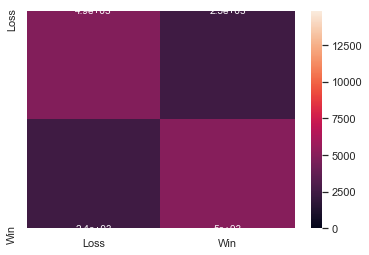

In [7]:
lr.analyze()

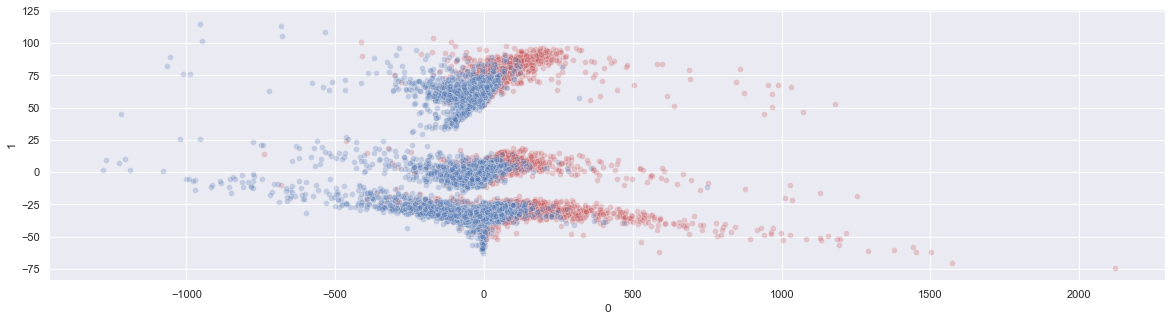

In [8]:
ju.plot_2d(X_test, y_predict_lr)

In [9]:
lr.save()

# KNN

In [10]:

# train our model

knn = ModelWrapper(KNeighborsClassifier(n_jobs = N_JOBS),
                   X_train,
                   y_train,
                   X_test,
                   y_test).fit()
y_predict_knn = knn.predict()

Model Score: 0.8079465731246627

              precision    recall  f1-score   support

        Loss       0.79      0.83      0.81      7378
         Win       0.83      0.78      0.80      7446

    accuracy                           0.81     14824
   macro avg       0.81      0.81      0.81     14824
weighted avg       0.81      0.81      0.81     14824

      Loss   Win
Loss  6147  1231
Win   1616  5830


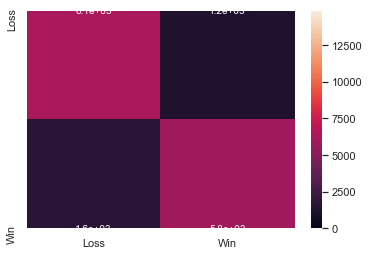

In [11]:
knn.analyze()

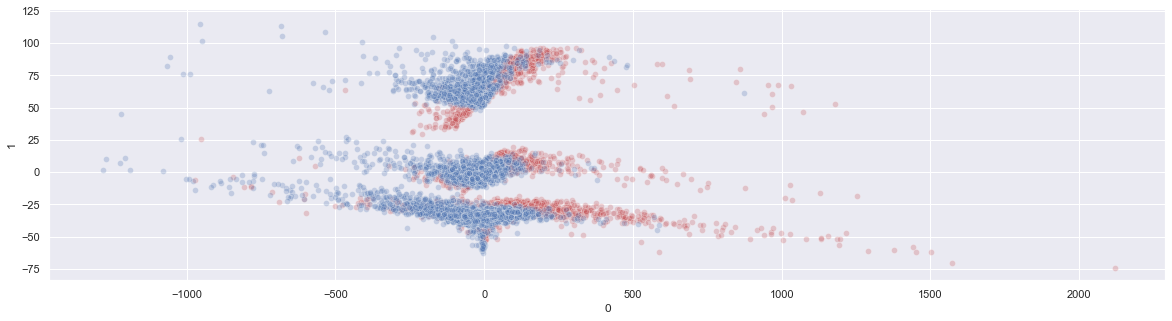

In [12]:
ju.plot_2d(X_test, y_predict_knn)

In [13]:
knn.save()

# Decision Tree

In [14]:

# train our model

dt = ModelWrapper(DecisionTreeClassifier(random_state = RSTATE),
                   X_train,
                   y_train,
                   X_test,
                   y_test).fit()
y_predict_dt = dt.predict()

Model Score: 0.9191851052347545

              precision    recall  f1-score   support

        Loss       0.92      0.92      0.92      7378
         Win       0.92      0.92      0.92      7446

    accuracy                           0.92     14824
   macro avg       0.92      0.92      0.92     14824
weighted avg       0.92      0.92      0.92     14824

      Loss   Win
Loss  6799   579
Win    619  6827


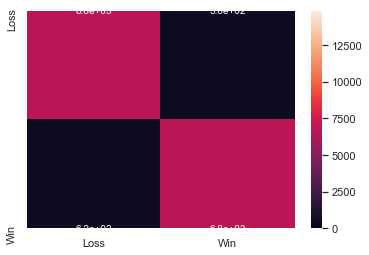

In [15]:
dt.analyze()

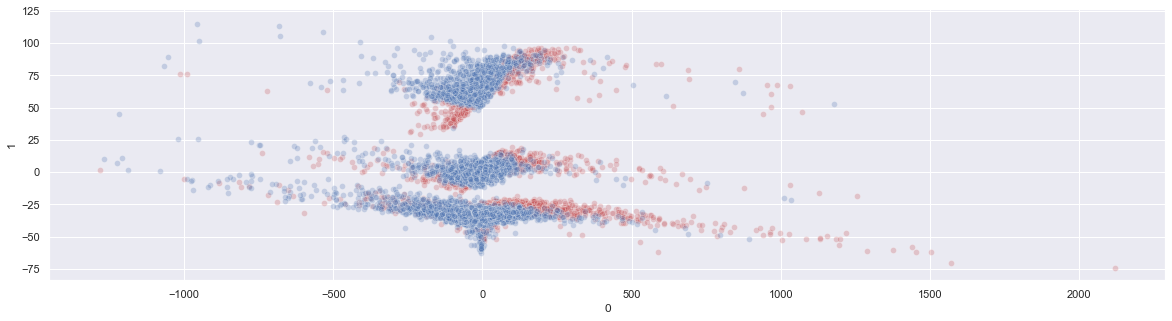

In [16]:
ju.plot_2d(X_test, y_predict_dt)

In [17]:
dt.save()

# Random Forest Classifier

In [18]:

# train our model

rf = ModelWrapper(RandomForestClassifier(random_state=RSTATE, verbose=1),
                   X_train,
                   y_train,
                   X_test,
                   y_test).fit()
y_predict_rf = rf.predict()

//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


Model Score: 0.7564085267134377

              precision    recall  f1-score   support

        Loss       0.73      0.80      0.77      7378
         Win       0.78      0.71      0.75      7446

    accuracy                           0.76     14824
   macro avg       0.76      0.76      0.76     14824
weighted avg       0.76      0.76      0.76     14824

      Loss   Win
Loss  5916  1462
Win   2149  5297


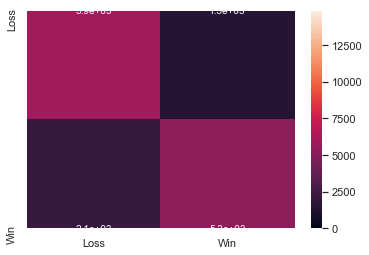

In [19]:
rf.analyze()

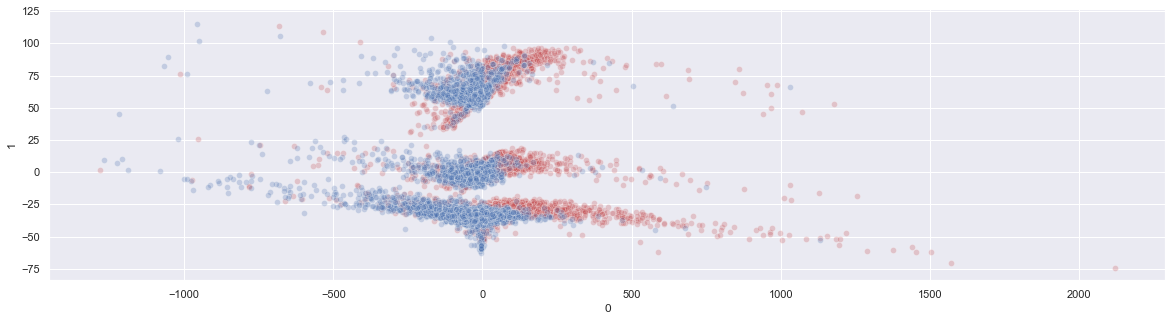

In [20]:
ju.plot_2d(X_test, y_predict_rf)

In [21]:
rf.save()

# Gradient Boosting

In [22]:

# train our model

gb = ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                   X_train,
                   y_train,
                   X_test,
                   y_test).fit()
y_predict_gb = gb.predict()

      Iter       Train Loss   Remaining Time 
         1           1.3153           10.28m
         2           1.2572            9.84m
         3           1.2087            9.78m
         4           1.1699            9.69m
         5           1.1376            9.53m
         6           1.1111            9.32m
         7           1.0795            9.16m
         8           1.0528            9.05m
         9           1.0318            8.90m
        10           1.0104            8.81m
        20           0.8858            7.67m
        30           0.8207            6.74m
        40           0.7857            5.82m
        50           0.7618            4.82m
        60           0.7462            3.81m
        70           0.7204            2.85m
        80           0.6997            1.89m
        90           0.6759           56.66s
       100           0.6598            0.00s


Model Score: 0.8602941176470589

              precision    recall  f1-score   support

        Loss       0.85      0.88      0.86      7378
         Win       0.88      0.84      0.86      7446

    accuracy                           0.86     14824
   macro avg       0.86      0.86      0.86     14824
weighted avg       0.86      0.86      0.86     14824

      Loss   Win
Loss  6497   881
Win   1190  6256


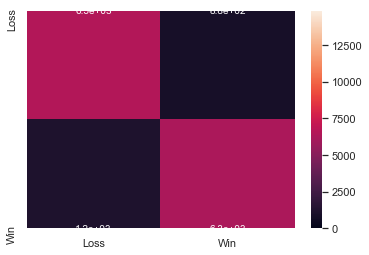

In [23]:
gb.analyze()

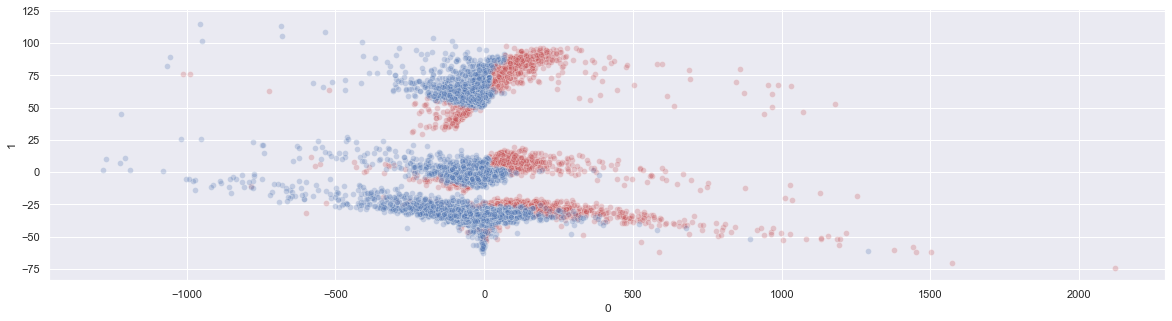

In [24]:
ju.plot_2d(X_test, y_predict_gb)

In [25]:
gb.save()

# AdaBoost

In [26]:
ab = ModelWrapper(AdaBoostClassifier(random_state=RSTATE),
                   X_train,
                   y_train,
                   X_test,
                   y_test).fit()
y_predict_ab = ab.predict()

Model Score: 0.7558014031300594

              precision    recall  f1-score   support

        Loss       0.74      0.79      0.76      7378
         Win       0.78      0.72      0.75      7446

    accuracy                           0.76     14824
   macro avg       0.76      0.76      0.76     14824
weighted avg       0.76      0.76      0.76     14824

      Loss   Win
Loss  5822  1556
Win   2064  5382


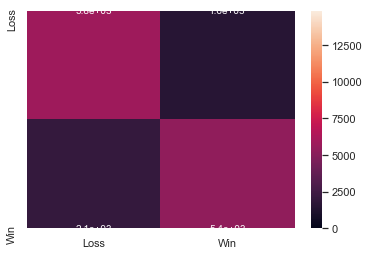

In [27]:
ab.analyze()

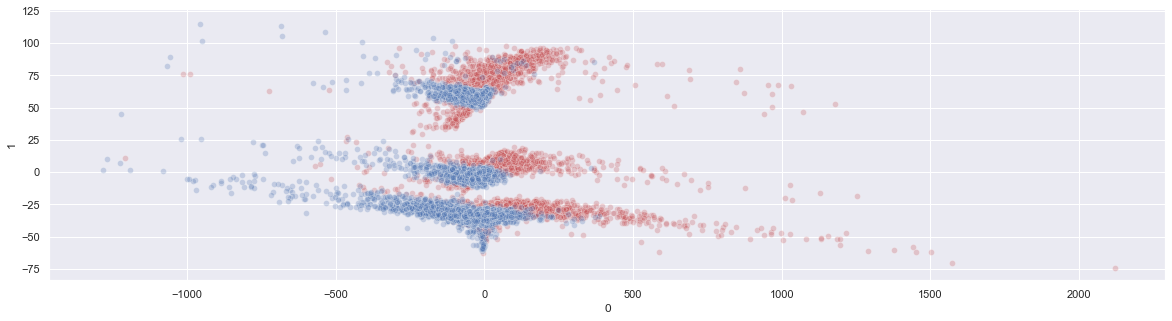

In [28]:
ju.plot_2d(X_test, y_predict_ab)

In [29]:
ab.save()

# Results

* Decision Tress is still our best model, although adding this data decreased our performance to be about 1% (back to diff+ohe_player performance)
* No change in performance for Ada Boost or Logistic regression or Gradient Boost
* Around 5% decrease in accuracy for KNN and Random Forest

In [30]:
report = pd.read_csv(ModelWrapper.report_file)
report.tail(5)

,model,description,data_file,start_year,accuracy,confusion_matrix,classification_report,model_file
19,KNeighborsClassifier,diff-ohe-history,../datasets/atp_matches_1985-2019_features-dif...,1998,0.807947,"{""0"": {""0"": 6147, ""1"": 1616}, ""1"": {""0"": 1231,...","{""Loss"": {""precision"": 0.7918330542316115, ""re...",../models/kneighborsclassifier-1998-2019-diff-...
20,DecisionTreeClassifier,diff-ohe-history,../datasets/atp_matches_1985-2019_features-dif...,1998,0.919185,"{""0"": {""0"": 6799, ""1"": 619}, ""1"": {""0"": 579, ""...","{""Loss"": {""precision"": 0.916554327311944, ""rec...",../models/decisiontreeclassifier-1998-2019-dif...
21,RandomForestClassifier,diff-ohe-history,../datasets/atp_matches_1985-2019_features-dif...,1998,0.756409,"{""0"": {""0"": 5916, ""1"": 2149}, ""1"": {""0"": 1462,...","{""Loss"": {""precision"": 0.7335399876007439, ""re...",../models/randomforestclassifier-1998-2019-dif...
22,GradientBoostingClassifier,diff-ohe-history,../datasets/atp_matches_1985-2019_features-dif...,1998,0.860294,"{""0"": {""0"": 6497, ""1"": 1190}, ""1"": {""0"": 881, ...","{""Loss"": {""precision"": 0.8451931832964745, ""re...",../models/gradientboostingclassifier-1998-2019...
23,AdaBoostClassifier,diff-ohe-history,../datasets/atp_matches_1985-2019_features-dif...,1998,0.755801,"{""0"": {""0"": 5822, ""1"": 2064}, ""1"": {""0"": 1556,...","{""Loss"": {""precision"": 0.7382703525234593, ""re...",../models/adaboostclassifier-1998-2019-diff-oh...


Text(0.5, 1.0, 'Model Accuracy')

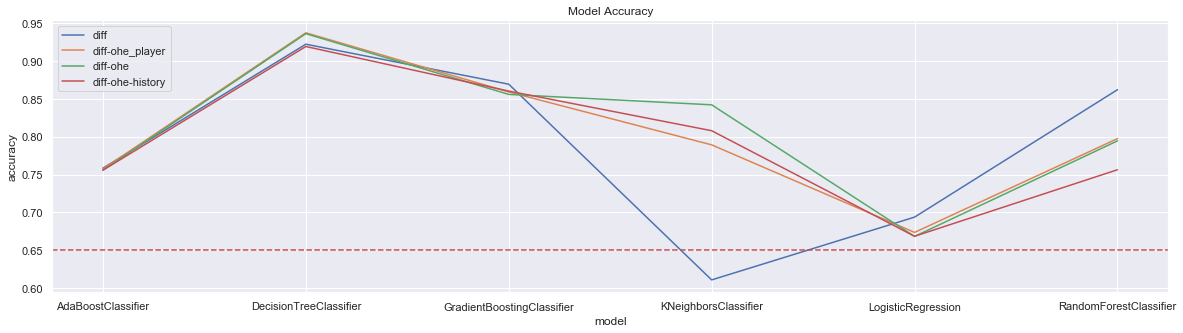

In [31]:
f, a = plt.subplots(1, 1, figsize=(20, 5))

descs = report.description.unique()

for desc in descs:
    report_desc = report[report.description == desc]
    sns.lineplot(x="model", y="accuracy", data=report_desc, label=desc)

a.axhline(0.65, ls='--', color='r')
a.set_title(f"Model Accuracy")